### ZoKrates Benchmarking

#### Functionality:
This notebook benchmarks the gas costs for different .zok functions. By setting __max_inputs__ programms with __[1 - max_inputs]__ will be generated.

E.g.
__max_inputs = 3__ will generate the following programms, deploy and execute them, and plot the gas usage for each programm

```
def main(field a):
	 return a

def main(field a, field b):
	 return a, b

def main(field a, field b, field c):
	 return a, b, c
```

#### Requirements for running:
- Geth or similar blockchain client running
- ZoKrates is installed locally (via install script)
- solc is installed globally (npm i -g solc)

#### Running Geth with Istanbul HF:
- Install Geth
- Initialize private chain with custom genesis:
    ```
    geth --datadir chain init genesis.json
    ```
- Run local private chain with miners targeting 100,000,000 block gas limit: 
    ``` 
    geth --port 3000 --networkid 58342 --nodiscover --datadir="chain" --maxpeers=0 --rpc --rpcport 8545 --rpcaddr 127.0.0.1 --rpccorsdomain "*" --rpcapi "eth,net,web3" --nodiscover --allow-insecure-unlock --unlock 0xD51E15b8580D7D1dcBD8FcfD8B712E45807BC305 --password pass --etherbase 0xD51E15b8580D7D1dcBD8FcfD8B712E45807BC305 --mine --minerthreads=1   --miner.gastarget 100000000 --miner.gaslimit 100000000
    ```

### Installing Dependencies:


In [1]:
import sys
!{sys.executable} -m pip install web3
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Imports

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os # paths
import shutil # file operations
from itertools import chain # operate on iterators like ranges
from web3 import Web3
w3 = Web3(Web3.HTTPProvider("http://127.0.0.1:8545"))
w3.eth.defaultAccount = w3.eth.accounts[0]


### Benchmark Configuration:
Set max number of inputs for the function. proving_scheme only accepts g16 for now, since thats the only available option in the install script version of ZoKrates. Once they are implemented, they can be choosen via provided variable.

In [3]:
max_inputs = 300 # largest number of contract inputs
step = 50 # increment in number of inputs between two experiments
trend_factor = 2
proving_scheme = "g16"
target_dir = './target' # directory generated files are stored in
blockgaslimit = 100000000

# Check last block actually has the expected block gas limit
last_block_gaslimit = w3.eth.getBlock('latest').gasLimit
if blockgaslimit != last_block_gaslimit:
    print('Warning: Last block gas limit is != configured gas limit: ' + str(last_block_gaslimit) + ' != ' + str(blockgaslimit) )

### Generate ZoKrates Benchmark files:

In [4]:
# function for naming function parameters with chars. Converts number to char [a-z].
# 1 -> a, 26 -> z, 27 -> za
def name_inputs(num, acc=""):
    if num > 26:
        acc += chr(122)
        return name_inputs(num - 26, acc)
    else:
        return acc + chr(num + 96)

# generates valid ZoKrates functions with given number of inputs
def generate_function(input_num, directory):
    function_name = 'def main('
    function = "\n\t return "
    function_return = " -> ():"
    if input_num == 0:
        function_name = "def main()"
    elif input_num == 1:
        function_name = "def main(field a)"
    else:
        for i in range(1, input_num + 1):
            if i != input_num:
                function_name += ('field ' + name_inputs(i) + ', ')
            else:
                function_name += ('field ' + name_inputs(i) + ')')

    write_files(function_name + function_return + function, input_num, directory)
    
# writes .zok files
def write_files(content, input_num, directory):
    file = open(directory + '/' + str(input_num) + "-benchmark.zok", "w")
    file.write(content)
    file.close()

# writes .zok files
def clean_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)
    
# Cleans target directory
clean_dir(target_dir)

# Generates test .zok files based on max_input and step
inputlist = list(chain([0],range(step, max_inputs + 1, step)))

for i in inputlist:
    generate_function(i,target_dir)
print("Success! Files have been created")




Success! Files have been created


### Compile and deploy

In [5]:
results_deploy = []
results_verify = []
    
def deploy_and_call(no_input):
    data = get_proof() 
    
#   Deploy Contract:
    if no_input:
        bytecode = open('zero-input-verifier_sol_Verifier.bin', 'r').read()
        abi = open('zero-input-verifier_sol_Verifier.abi', 'r').read()
    else:
        bytecode = open('verifier_sol_Verifier.bin', 'r').read()
        abi = open('verifier_sol_Verifier.abi', 'r').read()
    contract = w3.eth.contract(abi=abi, bytecode=bytecode)
    tx_hash = contract.constructor().transact({'gas': blockgaslimit})
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    results_deploy.append(tx_receipt.gasUsed)
    contract = w3.eth.contract(address=tx_receipt.contractAddress, abi=abi)
    
#   Call verify function
    if no_input:
        tx_hash = contract.functions.verifyTx(data[0]).transact({'gas': blockgaslimit})
    else:
        tx_hash = contract.functions.verifyTx(data[0], data[1]).transact({'gas': blockgaslimit})
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    results_verify.append(tx_receipt.gasUsed)
    
def get_proof():
    with open('proof.json') as f:
        data = json.load(f)
        f.close()
        return (format_proof(data['proof']), format_inputs(data['inputs'])) 
    
# formats and returns proof data as decimal tuple
def format_proof(proof):
    converted = []
    for key in proof.keys():
        res = []
        converted.append(format_array(proof[key], res))       
    return tuple(converted)

#  convert inputs from hex to decimal
def format_inputs(inputs):
    res = []
    for i in inputs:
        res.append(int(i, 16))
    return res
    
# recursive function for converting the proof data from hex to decimal (needed because of web3.py) while keeping the nested nature of proof data
# only tested for g16 (because the only proof currently available with install script) but should work for any type of scheme
def format_array(arr, res = [], idx = None):
    for elem in arr:
        if type(elem) != list:
            if idx != None:
                res[idx].append(int(elem, 16))
            else:
                res.append(int(elem, 16))
        else:
            res.append([])
            format_array(elem, res, len(res)-1)
    return res
  
# set working directory to target_dir    
os.chdir(target_dir)

# copy special verifier for 0 inputs to target_dir
shutil.copyfile('../zero-input-verifier.sol', './zero-input-verifier.sol')
    
# compile zokrates programs, generate witness, deploy verifiaction contract and call    
for i in iter(inputlist):
    params = '3 '* i
    file = str(i) + '-benchmark.zok'
    !zokrates compile -i {i}-benchmark.zok --light
    !zokrates setup -s {proving_scheme} --light
    if i == 0 :
        !zokrates compute-witness --light
    else:
        !zokrates compute-witness -a {params} --light
    !zokrates generate-proof -s {proving_scheme}
    
    !zokrates export-verifier -s {proving_scheme} -a v2
#   Compiling contract via solc cli
    if i == 0:
        !solcjs --abi --bin zero-input-verifier.sol
        deploy_and_call(True)
    else:
        !solcjs --abi --bin verifier.sol
        deploy_and_call(False)

print("Results Deploy:")
print(results_deploy)
print("Difference Deploy per input:")
xd = np.array(results_deploy)
print(np.diff(xd))
print("Results Verify:")
print(results_verify)
print("Difference Verify per input:")
xd = np.array(results_verify)
print(np.diff(xd))

# reset working_dir
os.chdir('./..')


Compiling 0-benchmark.zok

Compiled code written to 'out'
Number of constraints: 0
Performing setup...
Has generated 1 points
Setup completed.
Computing witness...

Witness: 

[]
Generating proof...
generate-proof successful: {
        "proof": {
            "a": ["0x01bef3e1adf6139084165015ac22931d7378d526ad4497e2220c83759440abf7", "0x263f2f93c40e985ef3c356149813deab9234d7646c44a80b5fc93c9d73bb6764"],
            "b": [["0x1b47cd4f7e22de2e86cdec29033260c77d48b886cbb5582460d2711f30f01ed1", "0x0d394304bac1e8ad9621da8b5d08b0b8536701f1c1e2e86bfd8a2ec61730e98b"], ["0x2b299e5cefb1a74ef64b824eea997b7f80b1fa99f668ec6461cff531f394d734", "0x268b541921df9b258d2cba24ec60eb0c65ad5440f96844a2745fcc66d09632a1"]],
            "c": ["0x13b62731fe5ca645878df3b5771ae26a214347b09f4e8358a9cfc9b660a5839f", "0x0cf55c28a5998a40a4aa20defbf84993cdbf8cb96e7d4553de28a8b2a9115650"]
        },
        "inputs": []
    }
Exporting verifier...
Finished exporting verifier.
zero-input-verifier.sol:567:9: Warning: Unus

In [6]:
def calc_trend_slope(x1, y1, x2, y2):
    return ((((y2 - y1)/(x2 - x1)) * (trend_factor * max_inputs - x1)) + y1) / 1000

    

### Deployment cost of contract

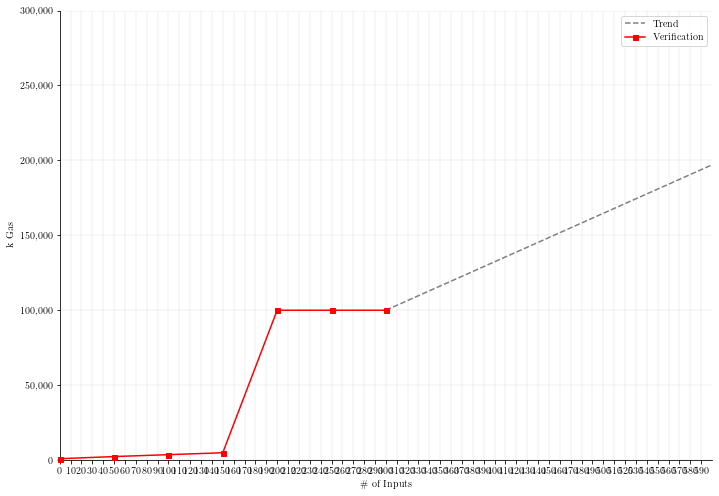

In [7]:
import math
import matplotlib as mpl

# Use Latex for text rendering. Commented out to render default font without latex.
mpl.rc('text', usetex=True)
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern']})

# calculate trendline slope
y_trend = calc_trend_slope(2, results_deploy[2], max_inputs, results_deploy[-1])

# plot
fig, ax = plt.subplots()
ax.plot([max_inputs, max_inputs * trend_factor], [results_deploy[-1] / 1000, y_trend], '--', label="Trend", color="grey") # plot trend first, so it's behind main plot
ax.plot(inputlist, [x / 1000 for x in results_deploy], '-rs', label="Verification", clip_on=False, zorder=100, markersize=5)
ax.axis([0, max_inputs*trend_factor, 0, results_deploy[-1]*3/1000])

# set x axis ticks
x_int = range(0, math.ceil(max_inputs*trend_factor),10) # calculate x axis values
ax.set_xticks(x_int)

# format y axis numbers
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adds a title and axes labels
# ax.set_title('Deployment Cost')
ax.set_xlabel('\# of Inputs')
ax.set_ylabel('k Gas')

# adds major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# adds legend
ax.legend() 

# set size
fig.set_size_inches(11.69,8.27) # a4 landscape

# save as pdf
fig.savefig('exports/deploy.pdf', bbox_inches='tight')


### Transaction cost of Verification

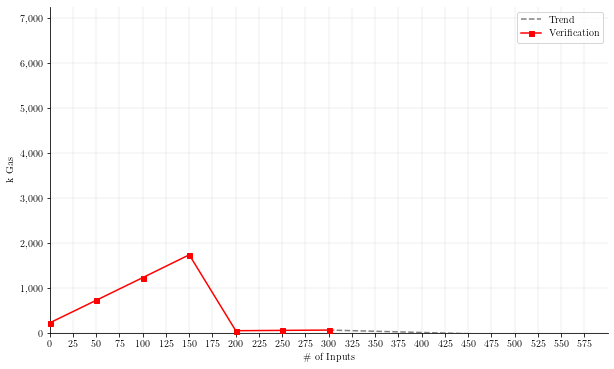

In [8]:
import math
import matplotlib as mpl

# Use Latex for text rendering. Commented out to render default font without latex.
mpl.rc('text', usetex=True)
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern']})

# calculate trendline slope
y_trend = calc_trend_slope(0, results_verify[0], max_inputs, results_verify[-1])

# blockgaslimit horizontal line
y_bgl = [10000, 10000]

# plot
fig, ax = plt.subplots()
ax.plot([max_inputs, max_inputs * trend_factor], [results_verify[-1] / 1000, y_trend], '--', label="Trend", color="grey") # plot trend first, so it's behind main plot
ax.plot(inputlist, [x / 1000 for x in results_verify], '-rs', label="Verification", clip_on=False, zorder=100, markersize=5)
ax.plot([0, max_inputs * trend_factor], y_bgl, 'b:', linewidth=0.5)
ax.axis([0, max_inputs*trend_factor, 0, results_deploy[2]*2/1000])


# set x axis ticks
x_int = range(0, math.ceil(max_inputs*trend_factor),math.ceil(step/2)) # calculate x axis values
ax.set_xticks(x_int)

# removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adds a title and axes labels
# ax.set_title('Deployment Cost')
ax.set_xlabel('\# of Inputs')
ax.set_ylabel('k Gas')

# adds major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# adds legend
ax.legend() 

# format y axis numbers
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# set size
fig.set_size_inches(10,6)

# save as pdf
fig.savefig('exports/verification.pdf', bbox_inches='tight')